Clone the Repostory

In [ ]:
!git clone https://github.com/pijush2022/Lane_detection.git

## Install the Requirements

- Install all the python dependencies
- After Installing dependencies, Restart the runtime. If you do not restart the runtime, the python will throw "module not found error"

In [1]:
!pip install -r road-detection/TwinLiteNet/requirements.txt

## Copy Dataset from Repository

- Our repository contains dataset.zip in datasets folder in the repository. copy that zip file to root

In [2]:
!cp road-detection/datasets/dataset.zip ./

## Unzip the file

In [3]:


!unzip dataset.zip

Archive:  dataset.zip
replace dataset/test/images/road_image_160.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace dataset/test/images/road_image_160.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: dataset/test/images/road_image_160.png  
  inflating: dataset/test/images/road_image_161.png  
  inflating: dataset/test/images/road_image_162.png  
  inflating: dataset/test/images/road_image_163.png  
  inflating: dataset/test/images/road_image_164.png  
  inflating: dataset/test/images/road_image_165.png  
  inflating: dataset/test/images/road_image_166.png  
  inflating: dataset/test/images/road_image_167.png  
  inflating: dataset/test/images/road_image_168.png  
  inflating: dataset/test/images/road_image_169.png  
  inflating: dataset/test/images/road_image_170.png  
  inflating: dataset/test/images/road_image_171.png  
  inflating: dataset/test/images/road_image_172.png  
  inflating: dataset/test/images/road_image_173.png  
  inflating: data

## Import the all the required libraries

In [4]:
import torch
import cv2
import torch.utils.data
import torchvision.transforms as transforms
import numpy as np
import os
import random
import math
from matplotlib import pyplot as plt
import torch.nn as nn

## Image transformation functions

- By paper author

In [5]:
def augment_hsv(img, hgain=0.015, sgain=0.7, vgain=0.4):
    """change color hue, saturation, value"""
    r = np.random.uniform(-1, 1, 3) * [hgain, sgain, vgain] + 1  # random gains
    hue, sat, val = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2HSV))
    dtype = img.dtype  # uint8

    x = np.arange(0, 256, dtype=np.int16)
    lut_hue = ((x * r[0]) % 180).astype(dtype)
    lut_sat = np.clip(x * r[1], 0, 255).astype(dtype)
    lut_val = np.clip(x * r[2], 0, 255).astype(dtype)

    img_hsv = cv2.merge((cv2.LUT(hue, lut_hue), cv2.LUT(sat, lut_sat), cv2.LUT(val, lut_val))).astype(dtype)
    cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR, dst=img)  # no return needed

In [6]:
def random_perspective(combination,  degrees=10, translate=.1, scale=.1, shear=10, perspective=0.0, border=(0, 0)):
    """combination of img transform"""
    # torchvision.transforms.RandomAffine(degrees=(-10, 10), translate=(.1, .1), scale=(.9, 1.1), shear=(-10, 10))
    # targets = [cls, xyxy]
    img, gray, line = combination
    height = img.shape[0] + border[0] * 2  # shape(h,w,c)
    width = img.shape[1] + border[1] * 2

    # Center
    C = np.eye(3)
    C[0, 2] = -img.shape[1] / 2  # x translation (pixels)
    C[1, 2] = -img.shape[0] / 2  # y translation (pixels)

    # Perspective
    P = np.eye(3)
    P[2, 0] = random.uniform(-perspective, perspective)  # x perspective (about y)
    P[2, 1] = random.uniform(-perspective, perspective)  # y perspective (about x)

    # Rotation and Scale
    R = np.eye(3)
    a = random.uniform(-degrees, degrees)
    # a += random.choice([-180, -90, 0, 90])  # add 90deg rotations to small rotations
    s = random.uniform(1 - scale, 1 + scale)
    # s = 2 ** random.uniform(-scale, scale)
    R[:2] = cv2.getRotationMatrix2D(angle=a, center=(0, 0), scale=s)

    # Shear
    S = np.eye(3)
    S[0, 1] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # x shear (deg)
    S[1, 0] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # y shear (deg)

    # Translation
    T = np.eye(3)
    T[0, 2] = random.uniform(0.5 - translate, 0.5 + translate) * width  # x translation (pixels)
    T[1, 2] = random.uniform(0.5 - translate, 0.5 + translate) * height  # y translation (pixels)

    # Combined rotation matrix
    M = T @ S @ R @ P @ C  # order of operations (right to left) is IMPORTANT
    if (border[0] != 0) or (border[1] != 0) or (M != np.eye(3)).any():  # image changed
        if perspective:
            img = cv2.warpPerspective(img, M, dsize=(width, height), borderValue=(114, 114, 114))
            gray = cv2.warpPerspective(gray, M, dsize=(width, height), borderValue=0)
            line = cv2.warpPerspective(line, M, dsize=(width, height), borderValue=0)
        else:  # affine
            img = cv2.warpAffine(img, M[:2], dsize=(width, height), borderValue=(114, 114, 114))
            gray = cv2.warpAffine(gray, M[:2], dsize=(width, height), borderValue=0)
            line = cv2.warpAffine(line, M[:2], dsize=(width, height), borderValue=0)



    combination = (img, gray, line)
    return combination

## Custom Dataset Class

- This custom dataset class is based on the dataset class written by the author but with slight modifications like path. we have adjusted the path according to the google colab.

In [7]:
class MyDataset(torch.utils.data.Dataset):
    '''
    Class to load the dataset
    '''
    def __init__(self, transform=None,valid=False):
        '''
        :param imList: image list (Note that these lists have been processed and pickled using the loadData.py)
        :param labelList: label list (Note that these lists have been processed and pickled using the loadData.py)
        :param transform: Type of transformation. SEe Transforms.py for supported transformations
        '''

        self.transform = transform
        self.Tensor = transforms.ToTensor()
        self.valid=valid
        if valid:
            self.root='dataset/validation/images'
            self.names=os.listdir(self.root)
        else:
            self.root='dataset/train/images/'
            self.names=os.listdir(self.root)

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        '''

        :param idx: Index of the image file
        :return: returns the image and corresponding label file.
        '''
        W_=640
        H_=360
        image_name=os.path.join(self.root,self.names[idx])

        image = cv2.imread(image_name)
        original_image = cv2.imread(image_name)
        label1 = cv2.imread(image_name.replace("images","segments").replace("jpg","png"), 0)
        label2 = cv2.imread(image_name.replace("images","lane").replace("jpg","png"), 0)
        if not self.valid:
            if random.random()<0.5:
                combination = (image, label1, label2)
                (image, label1, label2)= random_perspective(
                    combination=combination,
                    degrees=10,
                    translate=0.1,
                    scale=0.25,
                    shear=0.0
                )
            if random.random()<0.5:
                augment_hsv(image)
            if random.random() < 0.5:
                image = np.fliplr(image)
                label1 = np.fliplr(label1)
                label2 = np.fliplr(label2)

        label1 = cv2.resize(label1, (W_, H_))
        label2 = cv2.resize(label2, (W_, H_))
        image = cv2.resize(image, (W_, H_))

        _,seg_b1 = cv2.threshold(label1,1,255,cv2.THRESH_BINARY_INV)
        _,seg_b2 = cv2.threshold(label2,1,255,cv2.THRESH_BINARY_INV)
        _,seg1 = cv2.threshold(label1,1,255,cv2.THRESH_BINARY)
        _,seg2 = cv2.threshold(label2,1,255,cv2.THRESH_BINARY)

        seg1 = self.Tensor(seg1)
        seg2 = self.Tensor(seg2)
        seg_b1 = self.Tensor(seg_b1)
        seg_b2 = self.Tensor(seg_b2)
        seg_da = torch.stack((seg_b1[0], seg1[0]),0)
        seg_ll = torch.stack((seg_b2[0], seg2[0]),0)
        image = image[:, :, ::-1].transpose(2, 0, 1)
        image = np.ascontiguousarray(image)

        return original_image, image_name,torch.from_numpy(image),(seg_da,seg_ll)

## Intialize a dataloader

- Intialize a dataloader with batch size 8

In [8]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(MyDataset(), batch_size = 8, shuffle = True)

## Display images

- Show first sample of each mini-batch with size 8

dataset/train/images/road_image_138.png
dataset/train/images/road_image_69.png
dataset/train/images/road_image_122.png
dataset/train/images/road_image_49.png
dataset/train/images/road_image_71.png
dataset/train/images/road_image_61.png
dataset/train/images/road_image_75.png
dataset/train/images/road_image_98.png
dataset/train/images/road_image_137.png
dataset/train/images/road_image_143.png
dataset/train/images/road_image_117.png
dataset/train/images/road_image_144.png
dataset/train/images/road_image_35.png
dataset/train/images/road_image_51.png
dataset/train/images/road_image_114.png
dataset/train/images/road_image_26.png
dataset/train/images/road_image_125.png
dataset/train/images/road_image_85.png
dataset/train/images/road_image_116.png
dataset/train/images/road_image_52.png


<Figure size 10000x10000 with 0 Axes>

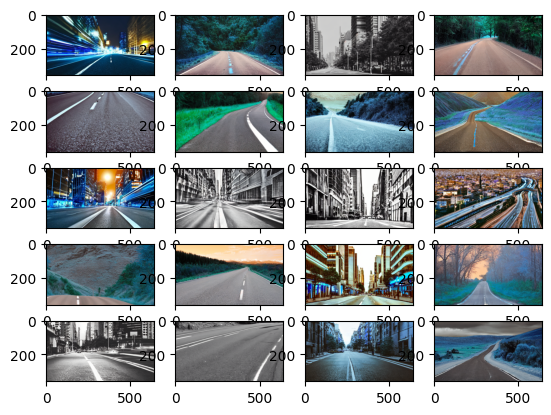

In [9]:
# Printing the first sample of the each minibatch of size 8

plt.figure(figsize = (100, 100))

f, axarr = plt.subplots(5, 4)
i = 0
j = 0

for batch in train_dataloader:
  original_image, image_name, input, target = batch
  print(image_name[0])
  axarr[i, j].imshow(original_image[0])
  j += 1
  if j%4 == 0:
    i += 1
    j = 0

plt.show()

## Load the pretrained model

In [11]:
import TwinLite as net


model = net.TwinLiteNet()
model = torch.nn.DataParallel(model)
model = model.cuda()
model.load_state_dict(torch.load('best.pth'))


<All keys matched successfully>

## Intialize loss and optimizer.

- This is based on the original code from paper author

In [12]:
from tqdm import tqdm
from loss import TotalLoss

lr = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr, (0.9, 0.999), eps=1e-08, weight_decay=5e-4)

criteria = TotalLoss()

In [13]:
args = dict()

args["lr"] = lr
args["max_epochs"] = 3
args["onGPU"] = True

In [14]:
args

{'lr': 0.0005, 'max_epochs': 3, 'onGPU': True}

## Intialize Polynomial Learning Rate Scheduler

- By Paper Author

In [15]:
def poly_lr_scheduler(args, optimizer, epoch, power=2):
    lr = round(args["lr"] * (1 - epoch / args["max_epochs"]) ** power, 8)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return lr

## Write a trainer function for each epoch

- By Paper Author

In [16]:
def train(args, train_loader, model, criterion, optimizer, epoch):
    model.train()

    total_batches = len(train_loader)
    pbar = enumerate(train_loader)
    pbar = tqdm(pbar, total=total_batches, bar_format='{l_bar}{bar:10}{r_bar}')
    for i, (_, _, input, target) in pbar:
        if args["onGPU"] == True:
            input = input.cuda().float() / 255.0
        output = model(input)

        # target=target.cuda()
        optimizer.zero_grad()

        focal_loss,tversky_loss,loss = criterion(output,target)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description(('%13s' * 1 + '%13.4g' * 3) %
                                     (f'{epoch}/{args["max_epochs"] - 1}', tversky_loss, focal_loss, loss.item()))

## Train the model with custom data and also print the loss

- This loss is based on the paper

In [17]:
for epoch in range(0, args["max_epochs"]):
    poly_lr_scheduler(args, optimizer, epoch)
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
    print("Learning rate: " +  str(lr))

    # train for one epoch
    model.train()
    train( args, train_dataloader, model, criteria, optimizer, epoch)
    model.eval()

Learning rate: 0.0005


          0/2       0.5133       0.3487        0.862: 100%|██████████| 20/20 [00:10<00:00,  1.99it/s]


Learning rate: 0.00022222


          1/2      0.08693      0.05467       0.1416: 100%|██████████| 20/20 [00:09<00:00,  2.09it/s]


Learning rate: 5.556e-05


          2/2      0.08697      0.05309       0.1401: 100%|██████████| 20/20 [00:08<00:00,  2.24it/s]


## Loss

- Loss in epoch 1: 0.862
- Loss in epoch 2: 0.1416
- Loss in epoch 3: 0.1401